# Minshu Dubey

## In this assignment, you will be performing experiments involving regression using the Beijing PM2.5 Data Set:

The hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included.
PM2. 5 refers to atmospheric particulate matter (PM) that have a diameter of less than 2.5 micrometers, which is about 3% the diameter of a human hair.
Commonly written as PM2.5, particles in this category are so small that they can only be detected with an electron microscope.
The data set can be found in the UCI Repository:  https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data (Links to an external site.)

## Your task is to create a well-documented report using a Google Colab Jupyter notebook to:

### a) Perform data scrubbing (handle missing data, normalization, scaling, etc.)
### b) Perform linear as well as non-linear regression on the dataset 
### c) Evaluate the performance of  each model using k-fold cross validation
### d) Plot and compare learning curves for all models 
### e) Fully discuss which model performs the best and why
 

[Source: https://royalsocietypublishing.org/doi/full/10.1098/rspa.2015.0257] (Links to an external site.)

 

## Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Importing and Loading Dataset
Some values was missing dataset for the coloumn pm2.5 so did imputation strategy mean of the coloumn and replaced NA values with 98.613(mean of the coloumn) in EXCEL FILE.

In [3]:
import pandas as pd
url = 'https://raw.githubusercontent.com/minsh30/Project4_PM2.5/master/PRSA_data_2010.1.1-2014.12.31.csv'
PM_25 = pd.read_csv(url)
PM_25.head(5)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,98.613,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,98.613,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,98.613,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,98.613,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,98.613,-20,-12.0,1018.0,NW,12.97,0,0


## Information of the dataset explaining which datatype they are

In [4]:
PM_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    43824 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


### Summary of the Dataset

In [5]:
# list of dtypes to include 
include =['object', 'float', 'int'] 
PM_25.describe(include=include)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824,43824.000000,43824.000000,43824.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SE,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15290,NaN,NaN,NaN
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613204,1.817246,12.448521,1016.447654,NaN,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,89.853296,14.433440,12.198613,10.268698,NaN,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,NaN,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,31.000000,-10.000000,2.000000,1008.000000,NaN,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,77.000000,2.000000,14.000000,1016.000000,NaN,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,132.000000,15.000000,23.000000,1025.000000,NaN,21.910000,0.000000,0.000000


In [6]:
#seeing how many object cbwd have.
PM_25['cbwd'].unique()

array(['NW', 'cv', 'NE', 'SE'], dtype=object)

In [7]:
PM_25["cbwd"].value_counts()

SE    15290
NW    14150
cv     9387
NE     4997
Name: cbwd, dtype: int64

### coverting object to int by label encoding.

In [8]:

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
PM_25["cbwd"] = lb_make.fit_transform(PM_25["cbwd"])
PM_25[["cbwd"]].head(30)
PM_25["cbwd"].unique()

array([1, 3, 0, 2])

In [9]:
PM_25["cbwd"].value_counts()

2    15290
1    14150
3     9387
0     4997
Name: cbwd, dtype: int64

### Note: now NW is converted to 1,
###          CV is converted to 3,
###          NE is converted to 0,
###          SE is converted to 2.

In [0]:
#Dropping some coloumns as it is giving no effect to the dataset for modelling.
PM_25 = PM_25.drop(columns=["No"])

In [11]:
PM_25.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,2010,1,1,0,98.613,-21,-11.0,1021.0,1,1.79,0,0
1,2010,1,1,1,98.613,-21,-12.0,1020.0,1,4.92,0,0
2,2010,1,1,2,98.613,-21,-11.0,1019.0,1,6.71,0,0
3,2010,1,1,3,98.613,-21,-14.0,1019.0,1,9.84,0,0
4,2010,1,1,4,98.613,-20,-12.0,1018.0,1,12.97,0,0


### Correlation of attributes against PM2.5

In [12]:

corr_matrix=PM_25.corr()
corr_matrix["pm2.5"].sort_values(ascending=False)

pm2.5    1.000000
cbwd     0.192408
DEWP     0.167334
day      0.080685
Is       0.019263
year    -0.014354
hour    -0.022573
month   -0.023533
PRES    -0.046298
Ir      -0.050224
TEMP    -0.088204
Iws     -0.239969
Name: pm2.5, dtype: float64

### As pm2.5 has the highest correlation with the Classification lable "cbwd"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe769151c88>,
      dtype=object)

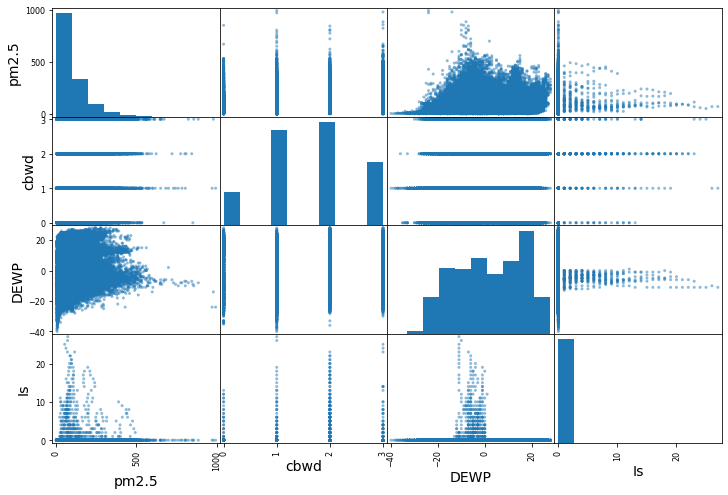

In [13]:
from pandas.plotting import scatter_matrix
attributes = ["pm2.5", "cbwd", "DEWP", "Is"]
scatter_matrix(PM_25[attributes],figsize=(12,8))

In [0]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics


### Doing Linear Regression on the two variables having highest correlation that is cbwd and pm2.5 

We have taken pm2.5 and cbwd for doing our analysis. Below is a 2-D graph between pm2.5 and cbwd.

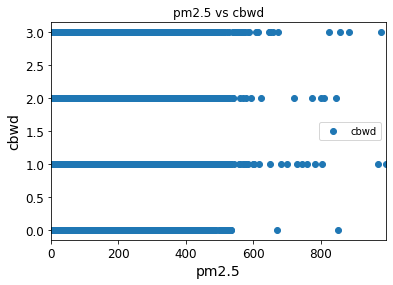

In [16]:
PM_25.plot(x='pm2.5', y='cbwd', style='o')  
plt.title('pm2.5 vs cbwd')  
plt.xlabel('pm2.5')  
plt.ylabel('cbwd')  
plt.show()

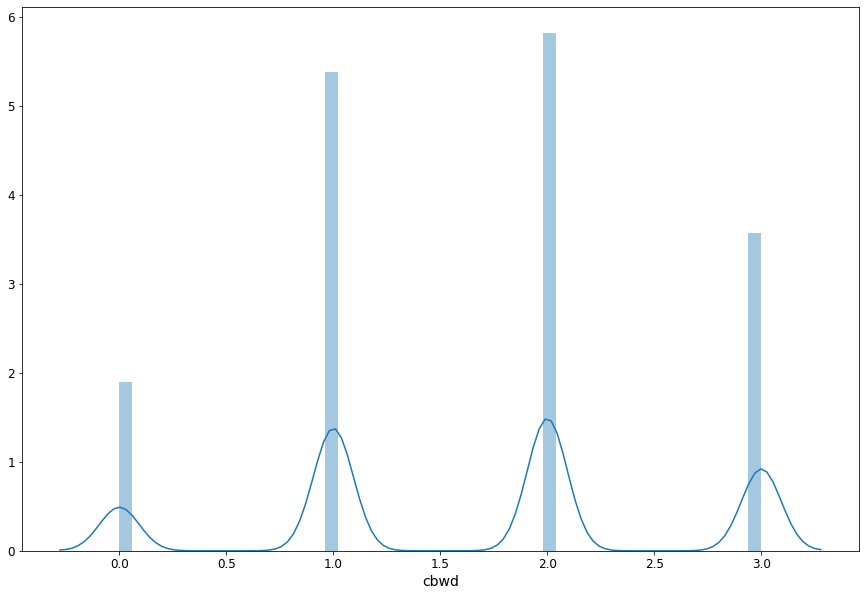

In [17]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(PM_25['cbwd'])

Our next step is to divide the data into “attributes” and “labels”.
Attributes are the independent variables while labels are dependent variables whose values are to be predicted. In our dataset, we only have two columns. We want to predict the cbwd depending upon the pm2.5 recorded. Therefore our attribute set will consist of the “pm2.5” column which is stored in the X variable, and the label will be the “cbwd” column which is stored in y variable.

In [0]:
X = PM_25['pm2.5'].values.reshape(-1,1)
y = PM_25['cbwd'].values.reshape(-1,1)

Next, we split 80% of the data to the training set while 20% of the data to test set using below code.
The test_size variable is where we actually specify the proportion of the test set.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

After splitting the data into training and testing sets, finally, the time is to train our algorithm. For that, we need to import LinearRegression class, instantiate it, and call the fit() method along with our training data.

In [20]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[1.46666299]
[[0.00198459]]


This means that for every one unit of change in pm2.5, the change in the cbwd is about 0.001%.
Now that we have trained our algorithm, it’s time to make some predictions. To do so, we will use our test data and see how accurately our algorithm predicts the percentage score. To make predictions on the test data, execute the following script

In [0]:
y_pred = regressor.predict(X_test)

In [23]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,1,1.800074
1,1,1.629399
2,0,2.075932
3,0,1.478571
4,1,1.857627
...,...,...
8760,2,1.649245
8761,2,1.621461
8762,2,2.403389
8763,0,1.662369


We can also visualize comparison result as a bar graph using the below script :
Note: As the number of records is huge, for representation purpose I’m taking just 25 records.

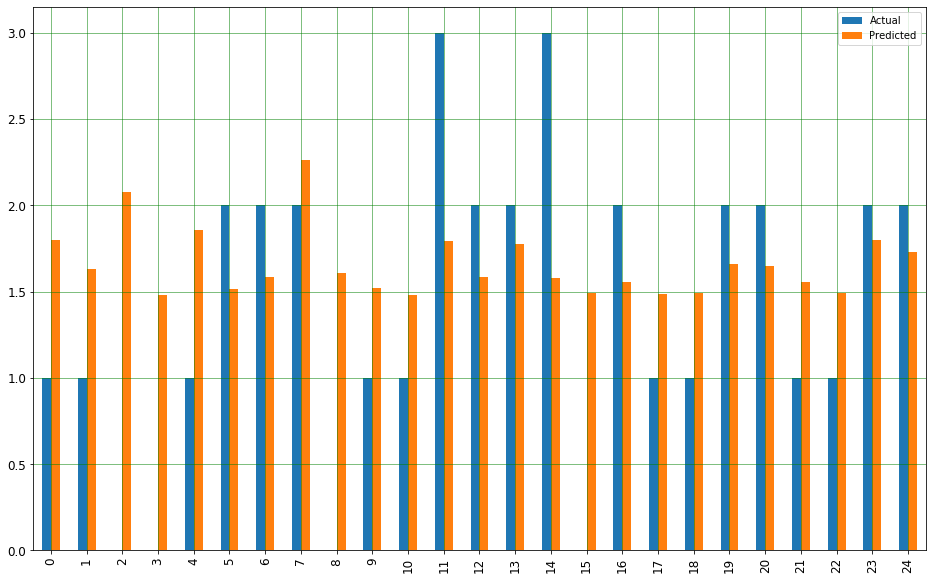

In [24]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

 our model is not very precise, the predicted percentages are not really close to the actual ones.
Let's plot our straight line with the test data :

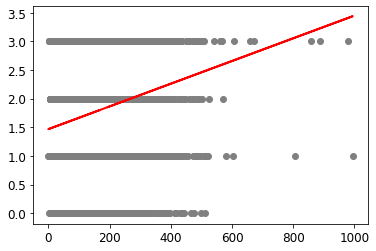

In [25]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.7840289643493557
Mean Squared Error: 0.862848762563443
Root Mean Squared Error: 0.9288965295249213


 our algorithm was not very accurate

## Multiple Linear Regression

In [0]:
X1 = PM_25[['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']].values
y1 = PM_25['cbwd'].values

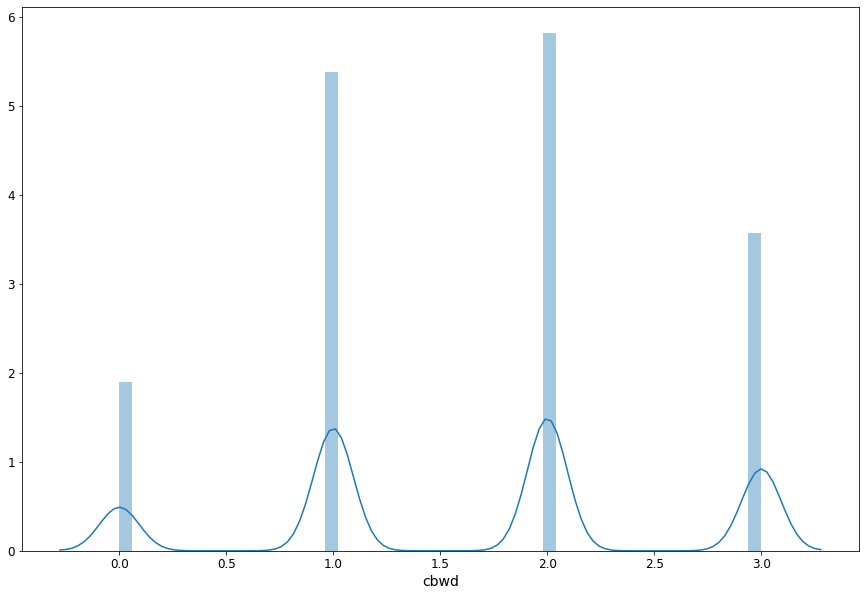

In [28]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(PM_25['cbwd'])

In [0]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0)

In [30]:
regressor = LinearRegression()  
regressor.fit(X1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

-40.36228765701798
[ 0.01977428 -0.00731623  0.00052524  0.01309549  0.00136449  0.01244972
  0.0018984   0.00197345 -0.0021491   0.01746853 -0.04281043]


In [0]:
y1_pred = regressor.predict(X1_test)

In [35]:
df2 = pd.DataFrame({'Actual': y1_test.flatten(), 'Predicted': y1_pred.flatten()})
df2


,Actual,Predicted
0,1,1.733866
1,1,1.527861
2,0,1.803843
3,0,1.375751
4,1,1.954657
...,...,...
8760,2,1.782094
8761,2,1.862590
8762,2,2.503169
8763,0,1.930928


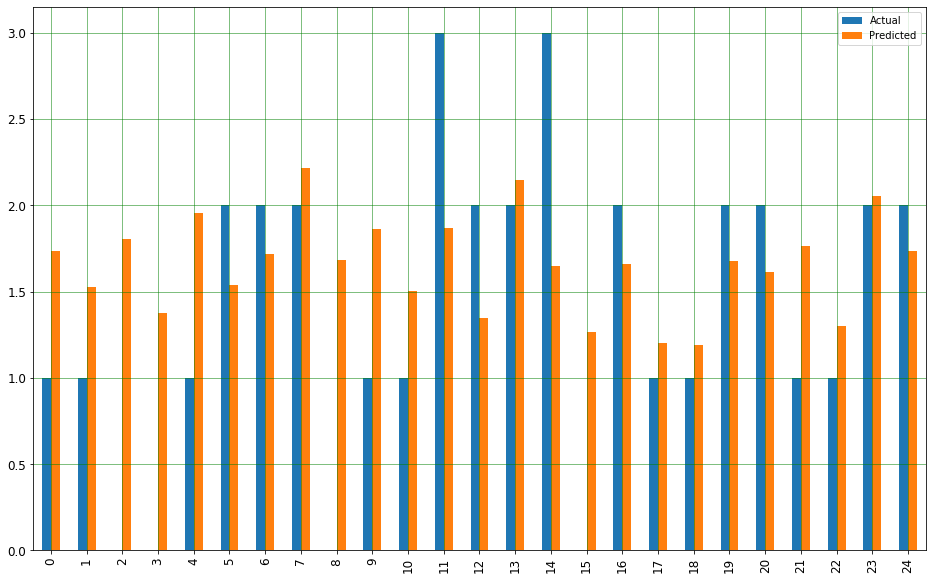

In [36]:
df3=df2.head(25)
df3.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Bar graph showing the difference between Actual and predicted value

In [74]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y1_test, y1_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y1_test, y1_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))

Mean Absolute Error: 0.7040079419920966
Mean Squared Error: 0.8051613523153628
Root Mean Squared Error: 0.897307835870925


 our algorithm was not very accurate

### Normal equation graph plot generation.

Saving figure generated_data_plot


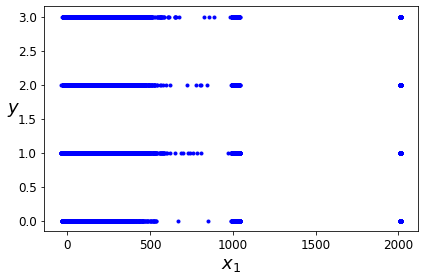

In [94]:
plt.plot(X_1, y1, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
save_fig("generated_data_plot")
plt.show()

### Taking two features from the dataset to make visualising and prediction easier for the modelling.

In [0]:
#let take x = pm2.5 and y = cbwd
X2 = PM_25[['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']].values
y2 = PM_25['cbwd'].values

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler

In [44]:
X_2= StandardScaler().fit_transform(X2)
X_2

array([[-1.41460097, -1.60170963, -1.67374446, ..., -0.44189385,
        -0.06935299, -0.13766709],
       [-1.41460097, -1.60170963, -1.67374446, ..., -0.37930644,
        -0.06935299, -0.13766709],
       [-1.41460097, -1.60170963, -1.67374446, ..., -0.34351365,
        -0.06935299, -0.13766709],
       ...,
       [ 1.41460097,  1.58805238,  1.73560822, ...,  4.37533654,
        -0.06935299, -0.13766709],
       [ 1.41460097,  1.58805238,  1.73560822, ...,  4.45572036,
        -0.06935299, -0.13766709],
       [ 1.41460097,  1.58805238,  1.73560822, ...,  4.51830776,
        -0.06935299, -0.13766709]])

### Now let's build a pipeline for preprocessing the numerical attributes:

For reference, here is the old solution based on a DataFrameSelector transformer (to just select a subset of the Pandas DataFrame columns), and a FeatureUnion

In [45]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_2, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Doing Cross validation

In [50]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_2, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
from sklearn.metrics import mean_squared_error

X2_predictions = lin_reg.predict(X_2)
lin_mse = mean_squared_error(y2, X2_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.8867498107897027

In [53]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y2, X2_predictions)
lin_mae

0.6934734544245987

In [55]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_2, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [58]:
X2_predictions = tree_reg.predict(X_2)
tree_mse = mean_squared_error(y2, X2_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_2, y2,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [59]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [0.96552483 1.02256093 0.92312299 1.0651812  1.02144956 1.01292424
 1.02156126 1.04366118 1.07754983 1.05551085]
Mean: 1.020904686830374
Standard deviation: 0.04424915199912361


In [60]:
lin_scores = cross_val_score(lin_reg, y2, X_2,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [nan nan nan nan nan nan nan nan nan nan]
Mean: nan
Standard deviation: nan


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected 2D array, got 1D array instead:
array=[2 3 3 ... 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 ... 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailed

In [61]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_2, y2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [62]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X_2, y2,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.66818537 0.74508514 0.64074647 0.75174379 0.71298613 0.75507247
 0.73453797 0.73217407 0.75660091 0.75915243]
Mean: 0.7256284745893306
Standard deviation: 0.038467370964623236


In [63]:
scores = cross_val_score(lin_reg, X_2, y2, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    10.000000
mean      0.887591
std       0.036800
min       0.812295
25%       0.877242
50%       0.891170
75%       0.913712
max       0.936006
dtype: float64

In [65]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_2, y2)
X2_predictions = svm_reg.predict(X_2)
svm_mse = mean_squared_error(y2, X2_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

0.8919679854970032

In [77]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y2)
lin_reg.intercept_, lin_reg.coef_

(1.694159334360166,
 array([ 0.02426321, -0.1112045 , -0.01294319,  0.09445815,  0.21412833,
         0.1056503 ,  0.18082022,  0.07458524, -0.24772075,  0.14507765,
        -0.18129917, -0.00921752,  0.01332768,  0.00527614,  0.00504506,
        -0.00205374, -0.02990496,  0.0209793 ,  0.0038069 , -0.00544992,
        -0.00131388,  0.01279153,  0.06717705,  0.00365229,  0.0193302 ,
         0.00592632, -0.05292945, -0.04717492, -0.02261453, -0.00607868,
        -0.00854271, -0.02153562, -0.01772137,  0.0022222 , -0.00765198,
         0.00284686, -0.00957617, -0.01014114,  0.00334399, -0.00436655,
        -0.00501329,  0.03116238,  0.00530329, -0.09781464,  0.08956024,
         0.02416879, -0.04231628, -0.00221089, -0.00026751, -0.0389595 ,
        -0.11491677,  0.12479251,  0.02759359, -0.05209852,  0.00356139,
         0.01548663, -0.081179  ,  0.15192809,  0.04478148,  0.01412439,
        -0.22728555,  0.12808667, -0.02922081,  0.05977564, -0.00927922,
         0.16832767, -0.0948661

In [0]:
X1_pm25 = X_2[:, [4]]

I am taking a single feature against polynominal regression because with multiple features it is giving dimension error and graph is not plotting.

In [117]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X1_pm25)
X1_pm25[0]

array([-2.27519416e-06])

In [118]:
X_poly[0]

array([-2.27519416e-06,  5.17650848e-12])

In [119]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.74372212]), array([[ 0.32901872, -0.08045542]]))

Saving figure quadratic_predictions_plot


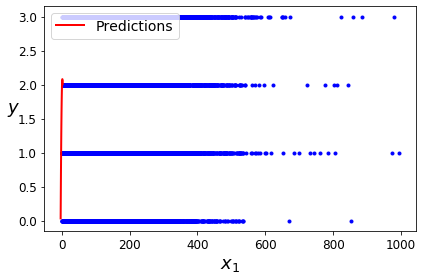

In [121]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)

save_fig("quadratic_predictions_plot")
plt.show()

In [0]:
X_new=np.linspace(-3, 3, 100).reshape(1, -1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X_2, y2, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

### Ridge Linear Regression

In [127]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X_pm25, y1)
ridge_reg.predict([X1_pm25])

ValueError: ignored

In [0]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X1, y1)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [123]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X_2, y2.ravel())
sgd_reg.predict([[1]])

NameError: ignored

Having problem with SGDRegressor because it is not getting defined.

In [0]:
X_pm25 = X_2[:, [ 4]]

**Doing regression testing using single feature.**

### Lasso Linear Regression

In [98]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_pm25, y2)
lasso_reg.predict([[1]])

array([1.74373942])

### ElasticNet Linear Regression

In [99]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_pm25, y2)
elastic_net.predict([[1]])

array([1.78752644])

Lasso and ElasticNet have almost same Prediction array.
ElasticNet is slightly better than Lasso 

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_2[:50], y2[:50].ravel(), test_size=0.2, random_state=10)

In [109]:
from sklearn.base import clone

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

KeyboardInterrupt: ignored

Plotting of the curves to show best model but i am getting error because of scaling issues though i did standard scaling with polynomial.

In [122]:

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

NameError: ignored